## XGBoost

XGBoost (Extreme Gradient Boosting) is a high-performance implementation of Gradient Boosted Decision Trees.It builds an ensemble of decision trees sequentially, where each new tree tries to correct the errors of the previous ones.

Why is it used:

1. It uses gradient boosting to minimize a loss function.

2. It adds regularization (L1/L2) to prevent overfitting.

3. It is optimized for speed using parallelism and efficient tree structures.

In [ ]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare data
X = df.drop(columns=["M", "V"])
y = df["M"] - 1  # Adjusting labels if needed

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = XGBClassifier(
    eval_metric="logloss",  
    booster="dart",  
    n_estimators=1000,  
    max_depth=10,  
    learning_rate=0.7,  
    subsample=0.8,  
    colsample_bytree=0.8,  
    reg_lambda=18,
    reg_alpha=0.6,
)

# Train model
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"XGBoost Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Save model
joblib.dump(model, "xgboost_model.pkl")


## HPO using Optuna

Optuna is searching for the best hyperparameter combination that maximizes accuracy on the test set.

Below is a breakdown of what each parameter controls and why it's being optimized:

1. Tree complexity / structure

These determine how the individual decision trees are shaped.

a. max_depth: Max depth of each tree

Controls model complexity (deep = more complex)

b. n_estimators:Number of trees to boost

Too many → overfitting

Too few → underfitting

2. Learning process (gradient boosting behavior)

a. learning_rate

Shrinks the contribution of each tree

Small values → more robust but require more trees

High values → faster but risk overshooting

b. subsample

Random proportion of samples used per tree

Prevents overfitting via stochastic training

c. colsample_bytree: Random proportion of features used per tree

Also reduces overfitting and increases diversity

3. Regularization (to prevent overfitting)

XGBoost adds L1/L2 regularization—this is a major advantage over vanilla GBMs.

a. reg_lambda (L2 regularization)

Penalizes large weights

Makes model more stable

b. reg_alpha (L1 regularization)

Encourages sparsity (prunes small weights)

Helps reduce feature noise

4. Booster type
a. booster = ['gbtree', 'dart']

gbtree: standard gradient boosted trees

dart: adds dropout to trees (like dropout in neural nets), improving generalization

In [ ]:
import pandas as pd
import optuna
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Load data
df = pd.read_csv("transformed_land_mines.csv")
X = df.drop(columns=["M", "V"])
y = df["M"] - 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna objective function
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.7),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 100.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "eval_metric": "mlogloss",
    }

    model = XGBClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Best params and model
print("Best Hyperparameters:", study.best_params)
print(f"Best Accuracy: {study.best_value:.4f}")

# Final model
final_model = XGBClassifier(**study.best_params, random_state=42, eval_metric="mlogloss")
final_model.fit(X_train, y_train)

# Save final model
joblib.dump(final_model, "xgboost_optuna_model.pkl")
print("Model saved as 'xgboost_optuna_model.pkl'")


## Catboost

CatBoost (Categorical Boosting) is a gradient-boosted decision tree algorithm developed by designed to work natively with categorical features and imbalanced datasets.

1. It handles categorical features automatically

No one-hot encoding, no label encoding, CatBoost transforms categories using ordered statistics, reducing target leakage.

2. It uses Ordered Boosting

A special way of building trees that avoids prediction shift and reduces overfitting.


Best Parameters: {'iterations': 618, 'depth': 7, 'learning_rate': 0.0024634872198337683, 'l2_leaf_reg': 8.3032432809646e-05, 'border_count': 208, 'bagging_temperature': 0.8524230621671868, 'eval_metric': 'Accuracy', 'verbose': 50, 'random_state': 42}
Best Optuna Accuracy: 0.6176470588235294
Final Test Accuracy (Optuna Run): 0.6176
0:	learn: 0.5259259	total: 1.92ms	remaining: 1.18s
50:	learn: 0.7518519	total: 196ms	remaining: 2.18s
100:	learn: 0.7740741	total: 409ms	remaining: 2.09s
150:	learn: 0.7777778	total: 599ms	remaining: 1.85s
200:	learn: 0.8037037	total: 825ms	remaining: 1.71s
250:	learn: 0.8074074	total: 986ms	remaining: 1.44s
300:	learn: 0.8222222	total: 1.15s	remaining: 1.21s
350:	learn: 0.8222222	total: 1.31s	remaining: 999ms
400:	learn: 0.8259259	total: 1.48s	remaining: 802ms
450:	learn: 0.8333333	total: 1.64s	remaining: 606ms
500:	learn: 0.8370370	total: 1.8s	remaining: 421ms
550:	learn: 0.8444444	total: 1.99s	remaining: 242ms


600:	learn: 0.8518519	total: 2.17s	remaining: 61.2ms
617:	learn: 0.8481481	total: 2.22s	remaining: 0us

CatBoost Accuracy (Re-run): 0.6176
Training Time: 2.38 seconds

Classification Report:

              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       0.75      1.00      0.86        12
           2       0.56      0.56      0.56        16
           3       0.55      0.55      0.55        11
           4       0.40      0.22      0.29        18

    accuracy                           0.62        68
   macro avg       0.60      0.67      0.62        68
weighted avg       0.58      0.62      0.58        68



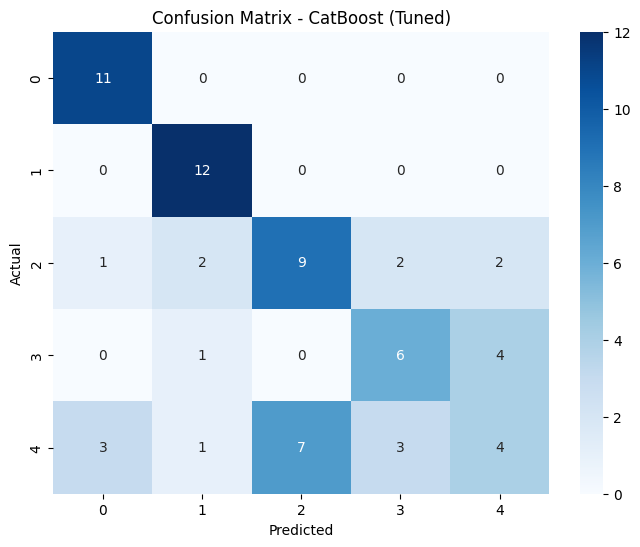


Model saved as catboost_model_tuned.pkl


In [14]:
import pandas as pd
import joblib
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare data
X = df.drop(columns=["M", "V"])
y = df["M"] - 1

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----------------------------------------------------
# Insert Optuna-optimized hyperparameters here
# ----------------------------------------------------
best_params = {
    "iterations": 618,
    "depth": 7,
    "learning_rate": 0.0024634872198337683,
    "l2_leaf_reg": 8.3032432809646e-05,
    "border_count": 208,
    "bagging_temperature": 0.8524230621671868,
    "eval_metric": "Accuracy",
    "verbose": 50,
    "random_state": 42
}

print("Best Parameters:", best_params)
print("Best Optuna Accuracy: 0.6176470588235294")
print("Final Test Accuracy (Optuna Run): 0.6176")

# Initialize CatBoost with tuned parameters
model = CatBoostClassifier(**best_params)

# Train
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

# Evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nCatBoost Accuracy (Re-run): {accuracy:.4f}")
print(f"Training Time: {end_time - start_time:.2f} seconds")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=True, yticklabels=True
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CatBoost (Tuned)")
plt.show()

# Save model
joblib.dump(model, "catboost_model_tuned.pkl")
print("\nModel saved as catboost_model_tuned.pkl")


## HPO using Optuna

Optuna is searching for the best hyperparameter combination that maximizes accuracy on the test set.

Below is a breakdown of what each parameter controls and why it's being optimized:

1. Model Complexity & Structure iterations

Maximum depth of each decision tree.

Larger depth → more complex trees (captures interactions)

Smaller depth → simpler, smoother model

2️. Learning Dynamics

Controls how much each tree contributes to the final model.

Low LR → stable, needs more iterations

High LR → risk of overshooting

3️. Regularization

L2 regularization applied to leaf weights.

Prevents too-large leaf values and reduces overfitting

CatBoost automatically balances this with ordered boosting

4️. Handling of Feature Splits

Number of splits used when converting continuous features into bins.

Important because CatBoost uses oblivious trees, so splits matter heavily

5️. Randomness & Bagging

Controls the amount of randomness in sampling rows.

0 → deterministic training

High → more random sampling, useful for reducing overfitting

[I 2025-11-18 06:08:00,668] A new study created in memory with name: no-name-fc5b3a31-e127-4c07-aef9-87363643ff30
[I 2025-11-18 06:08:01,306] Trial 0 finished with value: 0.5735294117647058 and parameters: {'iterations': 666, 'depth': 5, 'learning_rate': 0.015427297246297792, 'l2_leaf_reg': 3.2588574348658775e-05, 'border_count': 62, 'bagging_temperature': 0.5835508231202322}. Best is trial 0 with value: 0.5735294117647058.
[I 2025-11-18 06:08:07,046] Trial 1 finished with value: 0.5882352941176471 and parameters: {'iterations': 600, 'depth': 10, 'learning_rate': 0.015680893031128917, 'l2_leaf_reg': 0.0030884627693775375, 'border_count': 84, 'bagging_temperature': 0.679979454521077}. Best is trial 1 with value: 0.5882352941176471.
[I 2025-11-18 06:08:29,271] Trial 2 finished with value: 0.5882352941176471 and parameters: {'iterations': 943, 'depth': 11, 'learning_rate': 0.00015518079846516943, 'l2_leaf_reg': 0.004490401603846831, 'border_count': 185, 'bagging_temperature': 0.0965139663

Best Parameters: {'iterations': 618, 'depth': 7, 'learning_rate': 0.0024634872198337683, 'l2_leaf_reg': 8.3032432809646e-05, 'border_count': 208, 'bagging_temperature': 0.8524230621671868}
Best Accuracy: 0.6176470588235294
Final Test Accuracy: 0.6176


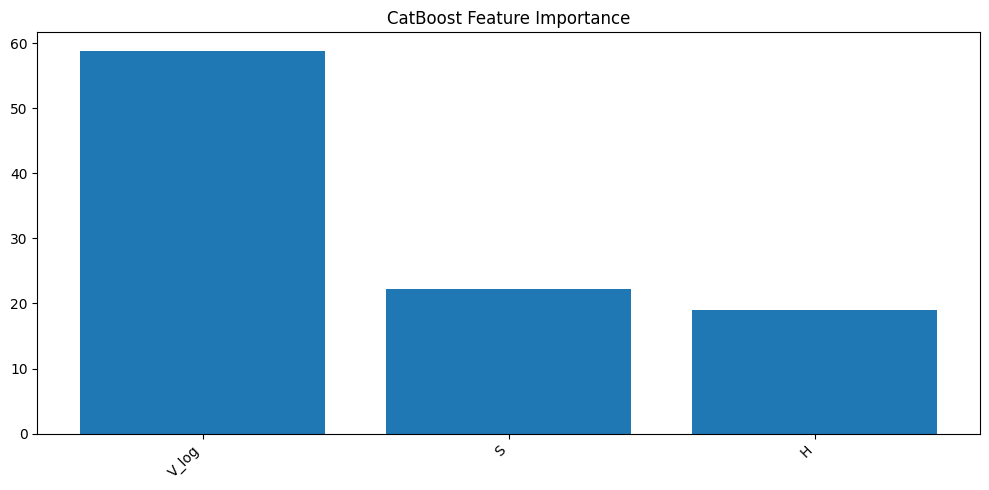

In [13]:
import pandas as pd
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare data
X = df.drop(columns=["M", "V"])
y = df["M"] - 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Optuna objective function
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 10, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "random_state": 42,
        "verbose": 0,
    }

    model = CatBoostClassifier(**params)

    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)

    return accuracy


# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Parameters:", study.best_params)
print("Best Accuracy:", study.best_value)


best_params = study.best_params
final_model = CatBoostClassifier(**best_params, random_state=42, verbose=0)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
final_acc = accuracy_score(y_test, y_pred)
print(f"Final Test Accuracy: {final_acc:.4f}")


# 1. Optuna optimization history
fig1 = optuna.visualization.plot_optimization_history(study)
fig1.show()

# 2. Optuna hyperparameter importance
fig2 = optuna.visualization.plot_param_importances(study)
fig2.show()

# 3. CatBoost Feature Importance
feature_importances = final_model.get_feature_importance()
feat_df = pd.DataFrame({
    "feature": X.columns,
    "importance": feature_importances
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(feat_df["feature"], feat_df["importance"])
plt.xticks(rotation=45, ha="right")
plt.title("CatBoost Feature Importance")
plt.tight_layout()
plt.show()



# Random Forest Classifier

Random Forest is an ensemble learning method that builds multiple decision trees and combines their predictions using majority vote (for classification).
Instead of relying on a single tree—which can overfit—Random Forests use:

Key Ideas:

1. Bootstrap sampling (random subsets of data)

2. Random feature selection at each split

3. Averaging predictions to reduce variance

4. Good at handling noisy or high-dimensional data

In [ ]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare data
X = df.drop(columns=["M", "V"])
y = df["M"] - 1  # Adjusting target as M - 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the final model (or use default hyperparameters here)
final_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=15, 
    min_samples_split=2, 
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    random_state=42
)

# Train the model
final_model.fit(X_train, y_train)

# Evaluate model
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"RandomForest Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Save the trained model
joblib.dump(final_model, "randomforest_model.pkl")
print("Model saved as 'randomforest_model.pkl'")


## HPO using Optuna

Optuna is searching for the best hyperparameter combination that maximizes accuracy on the test set.

Below is a breakdown of what each parameter controls and why it's being optimized:

1️. Model Size and Tree Complexity

a. Number of trees in the forest

More trees → higher accuracy, slower inference

Fewer trees → faster, might underfit

b. Maximum depth of each decision tree

Deep trees → more complex patterns, but risk of overfitting

Shallow trees → simpler model, may underfit

2️. Split Behavior

a. Minimum samples required to split a node

Higher values → smoother trees, less overfitting

b. Minimum samples in a leaf node

Larger leaves → more generalization, less noise

3️. Feature Sampling

Controls how many features each tree can consider when splitting

"sqrt" → common default

None → use all features

This randomness helps create diverse trees → stronger ensemble.

4. Bagging / Bootstrapping

a. Whether trees are trained on bootstrap samples.

True → classic Random Forest (recommended)

False → each tree sees the full dataset (less diverse)

In [ ]:
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare data
X = df.drop(columns=["M", "V"])
y = df["M"] - 1  # Adjusting target as M - 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Objective function to optimize hyperparameters
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 10, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Output best hyperparameters and accuracy
print(f"Best Hyperparameters: {study.best_params}")
print(f"Best Accuracy: {study.best_value:.4f}")

# Train final model with best hyperparameters
best_params = study.best_params
final_model = RandomForestClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate final model
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Final RandomForest Accuracy: {accuracy:.4f}")

# Save the final model
joblib.dump(final_model, "best_randomforest_model_optuna.pkl")
print("Model saved as 'best_randomforest_model_optuna.pkl'")


# Extra Trees Classifer

Extra Trees (Extremely Randomized Trees) is an ensemble learning method similar to Random Forest, but with more randomness injected into how trees are built.

It improves generalization by aggressively randomizing:

🔹 How splits are chosen

Extra Trees picks a random threshold for each feature

🔹 How the trees are constructed

More randomness → more diverse trees → lower variance


In [ ]:
import pandas as pd
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare data
X = df.drop(columns=["M", "V"])
y = df["M"] - 1

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize model
model = ExtraTreesClassifier(n_estimators=100, 
    max_depth=15, 
    min_samples_split=2, 
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    random_state=42)

# Train
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

# Evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"ExtraTrees Accuracy: {accuracy:.4f}")
print(f"Training Time: {end_time - start_time:.2f} seconds")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="BuPu", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ExtraTrees Classifier")
plt.show()

# Save model
joblib.dump(model, "extratrees_model.pkl")
print("Model saved as 'extratrees_model.pkl'")


## HPO using Optuna

Optuna is searching for the best hyperparameter combination that maximizes accuracy on the test set.

Below is a breakdown of what each parameter controls and why it's being optimized:

1. Tree Count & Depth
n_estimators

Number of trees.

More trees → better stability, slower

max_depth

Maximum depth of each tree.

Controls model complexity

2️. Split Behavior

Minimum samples needed to attempt a split.

Minimum samples allowed in each leaf.

These reduce overly deep or noisy branches.

3️. Feature Sampling Strategy
max_features

Controls how many features each tree considers:

"sqrt" → sqrt(#features)

"log2" → log2(#features)

None → all features

Float values (0.3, 0.5, 0.7) → use that proportion of features

This randomness makes each tree more unique → stronger ensemble.

4️. Bootstrapping
bootstrap (True/False)

True → train trees on resampled subsets

False → use full dataset (common for ExtraTrees)

In [ ]:
import optuna
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Features and labels
X = df.drop(columns=["M", "V"])
y = df["M"] - 1  # Adjusting labels to be 0-indexed

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Objective function for Optuna
def objective(trial):
    # Suggest hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Expanded max_features search space
    max_features = trial.suggest_categorical(
        'max_features', 
        ['sqrt', 'log2', None] + [0.3, 0.5, 0.7]  # Float options between 0 and 1
    )
    
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    # Initialize Extra Trees classifier with suggested parameters
    model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42
    )

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Create Optuna study and optimize the hyperparameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Output best hyperparameters and accuracy
print(f"Best Hyperparameters: {study.best_params}")
print(f"Best Accuracy: {study.best_value:.4f}")

# Train the final model with the best hyperparameters
best_params = study.best_params
final_model = ExtraTreesClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Extra Trees Accuracy: {accuracy:.4f}")


# Logistic Regression

Logistic Regression is a classical statistical learning method used for classification, not regression. It models the probability of each class using the logistic (sigmoid or softmax) function, and chooses the class with the highest predicted probability.

Logistic Regression often performs competitively with complex models on structured tabular datasets.

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



Logistic Regression Accuracy: 0.4412
Training Time: 0.03 seconds
              precision    recall  f1-score   support

           0       0.52      0.87      0.65        15
           1       0.88      1.00      0.93        14
           2       0.25      0.15      0.19        13
           3       0.00      0.00      0.00        13
           4       0.08      0.08      0.08        13

    accuracy                           0.44        68
   macro avg       0.34      0.42      0.37        68
weighted avg       0.36      0.44      0.39        68



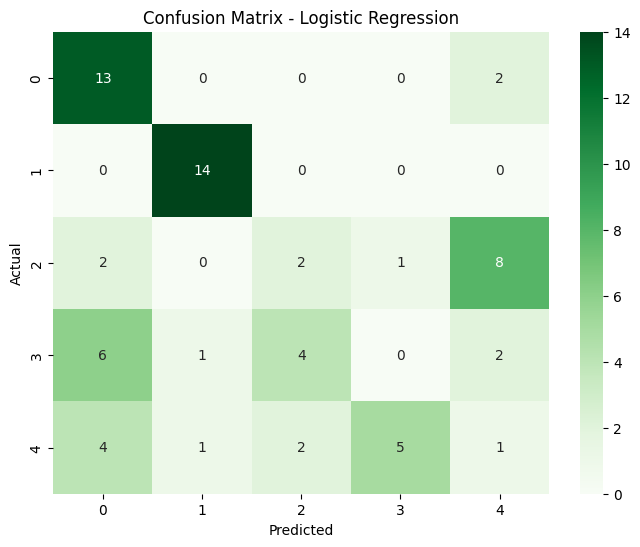

Model saved as 'logistic_regression_model.pkl'


In [17]:
import pandas as pd
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare data
X = df.drop(columns=["M", "V_log"])
y = df["M"] - 1  # Adjust target variable if necessary

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize Logistic Regression model
model = LogisticRegression(max_iter=1000, solver="lbfgs", multi_class="auto")

# Train
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

# Evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(f"Training Time: {end_time - start_time:.2f} seconds")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Save model
joblib.dump(model, "logistic_regression_model.pkl")
print("Model saved as 'logistic_regression_model.pkl'")


## HPO using Optuna

Optuna is searching for the best hyperparameter combination that maximizes accuracy on the test set.

Below is a breakdown of what each parameter controls and why it's being optimized:


1️. Regularization Strength

Inverse of regularization strength.

Small C → stronger regularization (simpler model)

Large C → weaker regularization (more flexible model)

This balances bias vs. variance.

2️. Optimization Solver

Algorithm used to optimize model weights:

"liblinear" → good for small datasets, L1/L2

"lbfgs" → efficient for multinomial logistic regression

"newton-cg" → robust, handles multiclass well

"saga" → supports elastic net, scalable

Choosing the right solver impacts convergence and accuracy.

3️. Iteration Limit

Maximum number of optimization steps.

Too low → solver may not converge

Higher values → stable convergence for tougher problems

In [9]:
import optuna
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Load landmine dataset
df = pd.read_csv("transformed_land_mines.csv")

# Features and labels
X = df.drop(columns=["M", "V"])
y = df["M"] - 1  # Adjust labels to 0–4

# Scale features (important for Logistic Regression!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Optuna objective function
def objective(trial):
    C = trial.suggest_float('C', 1e-5, 100, log=True)  # Regularization strength
    solver = trial.suggest_categorical(
        'solver', ['liblinear', 'lbfgs', 'saga', 'newton-cg']
    )
    max_iter = trial.suggest_int('max_iter', 100, 700)

    model = LogisticRegression(
        C=C,
        solver=solver,
        max_iter=max_iter,
        random_state=42,
        multi_class="auto"
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Hyperparameters:", study.best_params)
print(f"Best Accuracy: {study.best_value:.4f}")

# Train final model
best_params = study.best_params
final_model = LogisticRegression(
    **best_params,
    random_state=42,
    multi_class="auto"
)
final_model.fit(X_train, y_train)

# Final evaluation
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Logistic Regression Accuracy: {accuracy:.4f}")


[I 2025-11-18 06:03:01,878] A new study created in memory with name: no-name-38d345e3-c0d3-4a36-8f0b-73e3b5696cc0
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[I 2025-11-18 06:03:01,894] Trial 0 finished with value: 0.47058823529411764 and parameters: {'C': 15.899081990957455, 'solver': 'lbfgs', 'max_iter': 684}. Best is trial 0 with value: 0.47058823529411764.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[I 2025-11-18 06:03:01,902] Trial 1 finished with value: 

Best Hyperparameters: {'C': 0.4562925507822632, 'solver': 'saga', 'max_iter': 409}
Best Accuracy: 0.5000
Final Logistic Regression Accuracy: 0.5000


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## SVC

An SVC is a machine learning model based on Support Vector Machines (SVMs), an algorithm that finds an optimal hyperplane that separates classes in a high-dimensional space.

1. Works well on high-dimensional data

2. Effective for non-linear decision boundaries (with kernels)

3. Robust to outliers

4. Strong theoretical guarantees via margin maximization

5. SVMs operate by maximizing the margin, which is the distance between the decision boundary and the closest training points (support vectors).

SVM Accuracy: 0.3676
Training Time: 0.02 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.82      0.37        11
           1       1.00      0.92      0.96        12
           2       0.20      0.12      0.15        16
           3       0.50      0.09      0.15        11
           4       0.29      0.11      0.16        18

    accuracy                           0.37        68
   macro avg       0.44      0.41      0.36        68
weighted avg       0.42      0.37      0.33        68



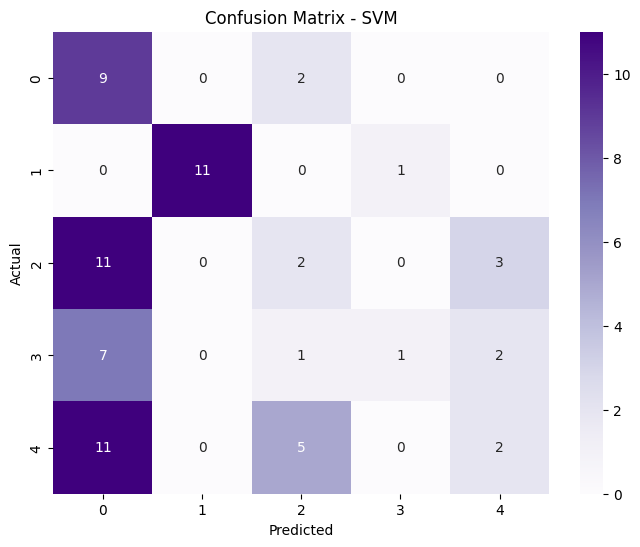

Model saved as 'svm_model.pkl'


In [10]:
import pandas as pd
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare data
X = df.drop(columns=["M", "V"])
y = df["M"] - 1

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize model
model = SVC(kernel="rbf", probability=True)

# Train
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

# Evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"SVM Accuracy: {accuracy:.4f}")
print(f"Training Time: {end_time - start_time:.2f} seconds")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.show()

# Save model
joblib.dump(model, "svm_model.pkl")
print("Model saved as 'svm_model.pkl'")


## HPO using Optuna

Optuna is searching for the best hyperparameter combination that maximizes accuracy on the test set.

Below is a breakdown of what each parameter controls and why it's being optimized:

RBF Kernel: Enables non-linear decision boundaries

probability=True: Allows generation of probability estimates via Platt scaling (useful for explainability + UI deployment)

In [ ]:
import pandas as pd
import optuna
import joblib
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare data
X = df.drop(columns=["M", "V"])
y = df["M"] - 1  # Adjusting target as M - 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    C = trial.suggest_loguniform("C", 1e-3, 1e3)  # Regularization parameter
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])  # Kernel type
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])  # Kernel coefficient
    degree = trial.suggest_int("degree", 2, 5)  # Degree for polynomial kernel

    # Initialize SVM model with suggested hyperparameters
    model = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, random_state=42)

    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create and optimize the study using Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# Output the best hyperparameters and accuracy
print(f"Best Hyperparameters: {study.best_params}")
print(f"Best Accuracy: {study.best_value:.4f}")

# Train the final model with the best hyperparameters
best_params = study.best_params
final_model = SVC(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Final SVM Accuracy: {accuracy:.4f}")

# Save the final model
joblib.dump(final_model, "best_svm_model_optuna.pkl")
print("Model saved as 'best_svm_model_optuna.pkl'")


## MLP Classifier

An MLPClassifier (Multi-Layer Perceptron) is a feed-forward neural network. It consists of multiple fully connected hidden layers and uses backpropagation to learn patterns in the data.

1. Learns non-linear relationships

2. Uses activation functions (ReLU in this case)

3. Trained with gradient-based optimization (AdamW / Adam)

4. Supports multiple output classes

5. MLPs are powerful for structured/tabular data when feature interactions are complex and non-linear.

[I 2025-11-18 05:45:13,855] A new study created in memory with name: no-name-6c405ad7-973c-4a51-bf4d-3cbd387cf5be
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 128) which is of type tuple.
  warnings.warn(message)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128) which is of type tuple.
  warnings.warn(message)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128, 64) which is of type tuple.
  warnings.warn(mes

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (338) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2025-11-18 05:45:20,039] Trial 0 finished with value: 0.6470588235294118 and parameters: {'hidden_layer_sizes': (256, 128, 64), 'alpha': 6.757438130438501e-05, 'learning_rate_init': 0.0007947803041932521, 'max_iter': 338}. Best is trial 0 with value: 0.6470588235294118.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 128) which is of type tuple.
  warnings.warn(message)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None,

 Best Hyperparameters:
{'hidden_layer_sizes': (256, 128), 'alpha': 0.00245354662051082, 'learning_rate_init': 0.012451931917413268, 'max_iter': 795}
 Best Accuracy: 0.7500


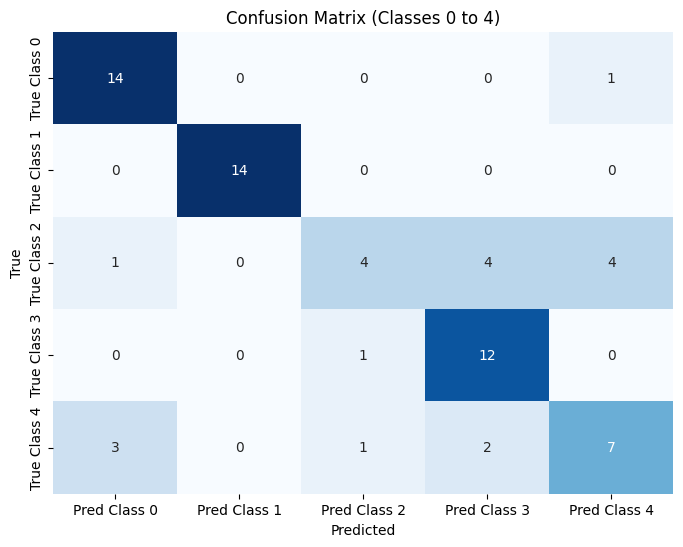


Final MLP Accuracy: 0.7500

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       1.00      1.00      1.00        14
           2       0.67      0.31      0.42        13
           3       0.67      0.92      0.77        13
           4       0.58      0.54      0.56        13

    accuracy                           0.75        68
   macro avg       0.74      0.74      0.72        68
weighted avg       0.74      0.75      0.73        68



['scaler_optuna_best_relu.pkl']

In [2]:
import pandas as pd
import joblib
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("transformed_land_mines.csv")
X = df.drop(columns=["M", "V"])
y = df["M"] - 1

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Optuna objective function with pruning
def objective(trial):
    hidden_layer_sizes = trial.suggest_categorical(
        "hidden_layer_sizes", [(128, 128), (256, 128), (256, 128), (256, 128, 64), (256, 128, 64)]
    )
    alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
    learning_rate_init = trial.suggest_float("learning_rate_init", 2e-4, 1e-1, log=True)
    max_iter = trial.suggest_int("max_iter", 300, 800)

    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation="relu",
        solver="adam",
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=max_iter,
        random_state=42
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Report intermediate accuracy 
    trial.report(accuracy, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return accuracy

# Run Optuna study with pruning
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100, timeout=600)  # Add timeout or other limits if needed

# Print best params
print(" Best Hyperparameters:")
print(study.best_params)
print(f" Best Accuracy: {study.best_value:.4f}")

# Train final model
best_params = study.best_params
final_model = MLPClassifier(
    **best_params,
    activation="relu",
    solver="adam",
    random_state=42
)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn for classes 0 to 4
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=[f'Pred Class {i}' for i in range(5)], 
            yticklabels=[f'True Class {i}' for i in range(5)])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Classes 0 to 4)')
plt.show()

print(f"\nFinal MLP Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

# Save model and scaler
joblib.dump(final_model, "mlp_optuna_best_relu.pkl")
joblib.dump(scaler, "scaler_optuna_best_relu.pkl")


## HPO using Optuna

Optuna is searching for the best hyperparameter combination that maximizes accuracy on the test set.

Below is what each parameter controls and why it's being optimized:

1️. Network Architecture
hidden_layer_sizes

This controls:

a. Number of layers

b. Number of neurons per layer

Model capacity (how complex a function it can learn)

2️. Regularization alpha

a. L2 regularization on network weights.

Higher → prevents overfitting

Lower → more expressive but risky

3️. Learning Dynamics learning_rate_init

a. Initial learning rate for the Adam(W) optimizer.

Low → stable but slow

High → fast but may overshoot

b. max_iter

Maximum number of training epochs.


Training Time: 0.56 seconds

 Final MLP Accuracy: 0.7941

 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       1.00      1.00      1.00        14
           2       0.71      0.38      0.50        13
           3       0.75      0.92      0.83        13
           4       0.69      0.69      0.69        13

    accuracy                           0.79        68
   macro avg       0.79      0.79      0.77        68
weighted avg       0.79      0.79      0.78        68



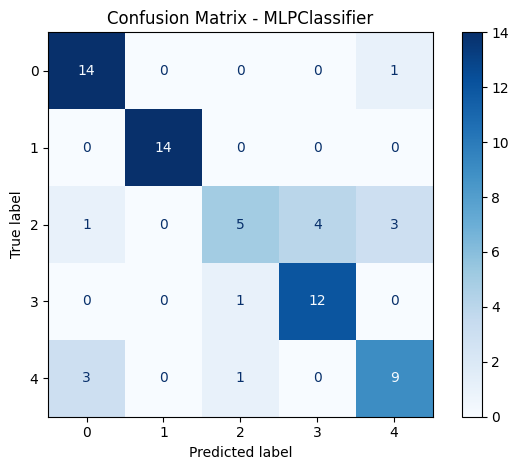

['scaler_optuna_best_relu.pkl']

In [3]:
import pandas as pd
import joblib
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("transformed_land_mines.csv")

# Prepare features and labels
X = df.drop(columns=["M", "V"])
y = df["M"] - 1  # Shift labels from 1–5 to 0–4

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Define the MLP model
clf = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    alpha=1.5533844813198423e-05,
    learning_rate_init=0.012213599390700235,
    max_iter=587,
    activation="relu",
    solver="adam",
    random_state=42
)

# Train the model and record time
start_time = time.time()
clf.fit(X_train, y_train)
end_time = time.time()
print(f"Training Time: {end_time - start_time:.2f} seconds")

# Evaluate model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n Final MLP Accuracy: {accuracy:.4f}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(
    clf, X_test, y_test, display_labels=[0, 1, 2, 3, 4], cmap="Blues"
)
plt.title("Confusion Matrix - MLPClassifier")
plt.tight_layout()
plt.show()

# Save model and scaler
joblib.dump(clf, "mlp_optuna_best_relu.pkl")
joblib.dump(scaler, "scaler_optuna_best_relu.pkl")


## Deployment

The final model was deployed with a Gradio application hosted inside a Jupyter Notebook. The interface loads the trained MLP model and StandardScaler, provides a clean form for entering feature values and outputs class predictions with probability visualizations. This makes the model easy to test, share and validate interactively.

In [15]:
import gradio as gr
import pandas as pd
import numpy as np
import joblib

# ----------------------------
# Load model & scaler
# ----------------------------
model = joblib.load("svm_model.pkl")
#scaler = joblib.load("catboost_model_tuned.pkl")

# ----------------------------
# Soil category mapping
# ----------------------------
SOIL_CHOICES = {
    "Dry and Sandy": 1,
    "Dry and Humus": 2,
    "Dry and Limy": 3,
    "Humid and Sandy": 4,
    "Humid and Humus": 5,
    "Humid and Limy": 6
}

# ----------------------------
# Validation + Preprocessing
# ----------------------------
def validate_and_prepare(V, H, soil_label, scaler, clamp=False):
    if V is None or H is None or soil_label is None:
        raise ValueError("All inputs (V, H, Soil Type) are required.")

    v_min, v_max = 0.0, 10.6
    h_min, h_max = 0.0, 20.0

    warning = ""

    # Voltage validation
    if V < v_min or V > v_max:
        if clamp:
            V = max(min(V, v_max), v_min)
            warning += f"Voltage clamped to [{v_min}, {v_max}]. "
        else:
            raise ValueError(f"Voltage must be in [{v_min}, {v_max}] volts.")

    # Height validation
    if H < h_min or H > h_max:
        if clamp:
            H = max(min(H, h_max), h_min)
            warning += f"Height clamped to [{h_min}, {h_max}] cm. "
        else:
            raise ValueError(f"Height must be in [{h_min}, {h_max}] cm.")

    # Soil validation
    if soil_label not in SOIL_CHOICES:
        raise ValueError(f"Soil must be one of: {list(SOIL_CHOICES.keys())}")
    
    S = SOIL_CHOICES[soil_label]

    # Log-transform V
    V_log = np.log1p(V)
    if not (0.0 <= V_log <= np.log1p(v_max) + 1e-6):
        raise ValueError("Transformed V_log out of bounds.")

    # Feature order: MUST match training
    X_row = np.array([[V_log, H, S]], dtype=float)

    # Apply saved scaler
    X_scaled = scaler.transform(X_row)

    return X_scaled, (warning.strip() if warning else None)

# ----------------------------
# Prediction function
# ----------------------------
def predict_landmine(V, H, soil_label):
    try:
        X_scaled, warning = validate_and_prepare(V, H, soil_label, scaler, clamp=True)

        pred_class = int(model.predict(X_scaled)[0])
        probs = model.predict_proba(X_scaled)[0]

        prob_dict = {f"Class {i}": float(probs[i]) for i in range(len(probs))}

        return {
            "Predicted Class": pred_class,
            "Probabilities": prob_dict,
            "Warning": warning
        }

    except Exception as e:
        return {"Error": str(e)}

# ----------------------------
# Gradio UI
# ----------------------------
demo = gr.Interface(
    fn=predict_landmine,
    inputs=[
        gr.Slider(0.0, 10.6, step=0.01, label="Voltage (V) [0–10.6 V]"),
        gr.Slider(0, 20, step=0.1, label="Height (H) [0–20 cm]"),
        gr.Dropdown(list(SOIL_CHOICES.keys()), label="Soil Type (S)")
    ],
    outputs=gr.JSON(label="Prediction Output"),
    title="Land Mine Classifier (Catboost)",
    description="Provide sensor readings to predict land mine type (Classes 0–4).",
    allow_flagging="never"
)

demo.launch(inline=True, share=True)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/gradio/interface.py:415: UserWarning:

The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.



* Running on local URL:  http://127.0.0.1:7866
* Running on public URL: https://25d977b585b01e6bf1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

/home/zeus/miniconda3/e